In [1]:
import pandas as pd
from pandas import DataFrame
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt

from collections import defaultdict

In [2]:
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier as RFC
import xgboost as xgb
from xgboost import XGBClassifier as XGB
from sklearn.ensemble import AdaBoostClassifier as ABC

In [3]:
import os
import re

csv_list = os.listdir("..\\data\\genus.reabund_feature_selected")  # list of files
pattern = re.compile(r'(0\.\d{2}_\d+\.csv)')  # check format of filename
csv_list = [pattern.match(x).group(0) for x in csv_list] # leave only the needed files
csv_list

['0.12_62.csv',
 '0.14_33.csv',
 '0.16_22.csv',
 '0.18_12.csv',
 '0.20_8.csv',
 '0.22_3.csv']

In [4]:
def plot_score_feature(scores, name="Default"):
    """ plot the ROC-AUC score of the model versus the correlation used to select features """
    plt.plot(np.arange(.12, .24, .02), scores, label="ROC-AUC score")
    plt.title(name)
    plt.grid(alpha=.1)
    plt.legend(loc='best')
    plt.xlabel("Feature Correlation Coefficient")
    plt.ylabel("ROC-AUC Score")

In [5]:
def kfold_feat_select(clf, param_grid, scores_across_datasets, kfold_num=4, grid_search_cv=4):
    models = defaultdict(list)
    
    # k-fold for each dataset with different # of features
    for file in csv_list:
        df = pd.read_csv(os.path.join("..\\data\\genus.reabund_feature_selected", file))
        df.drop(labels='id', axis=1, inplace=True)
        
        X = df.iloc[:, :-1]
        y = df.iloc[:, -1]
        
        kf = KFold(n_splits=kfold_num, random_state=42, shuffle=True)  # k-fold cross validation
        print(f"Processing file {file}:")
        
        scores = []
        for train_index, test_index in kf.split(X, y):
            # split train-test set
            X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y.iloc[train_index], y.iloc[test_index]
            
            # grid search for the best params
            gs = GridSearchCV(clf(),
                              param_grid,
                              scoring='roc_auc',
                              cv=grid_search_cv,
                              iid=False,
                              n_jobs=-1)
        
            gs.fit(X_train, y_train.values.ravel())  # train the model
            scores.append(gs.score(X_test, y_test))  # save the score of the current fold
            print(gs.best_params_)
            models[file].append(clf(**gs.best_params_)) # save the model with best params
        
        # print the score of each fold and the average
        print('[', ', '.join([f"{x:.3f}" for x in scores]), ']')
        score = np.mean(scores)
        print(f"The average score is {score:.3f}")
        scores_across_datasets.append(score)
        print()
    return models

## XGBoost

Processing file 0.12_62.csv:
{'learning_rate': 0.2, 'n_estimators': 2}
{'learning_rate': 0.1, 'n_estimators': 10}
{'learning_rate': 0.3, 'n_estimators': 30}
{'learning_rate': 0.2, 'n_estimators': 30}
[ 0.652, 0.649, 0.623, 0.610 ]
The average score is 0.634

Processing file 0.14_33.csv:
{'learning_rate': 0.1, 'n_estimators': 2}
{'learning_rate': 0.01, 'n_estimators': 50}
{'learning_rate': 0.2, 'n_estimators': 2}
{'learning_rate': 0.3, 'n_estimators': 5}
[ 0.645, 0.532, 0.514, 0.647 ]
The average score is 0.585

Processing file 0.16_22.csv:
{'learning_rate': 0.01, 'n_estimators': 20}
{'learning_rate': 0.2, 'n_estimators': 50}
{'learning_rate': 0.2, 'n_estimators': 10}
{'learning_rate': 0.01, 'n_estimators': 50}
[ 0.771, 0.463, 0.643, 0.816 ]
The average score is 0.673

Processing file 0.18_12.csv:
{'learning_rate': 0.01, 'n_estimators': 5}
{'learning_rate': 0.3, 'n_estimators': 50}
{'learning_rate': 0.3, 'n_estimators': 5}
{'learning_rate': 0.01, 'n_estimators': 50}
[ 0.703, 0.433, 0.65

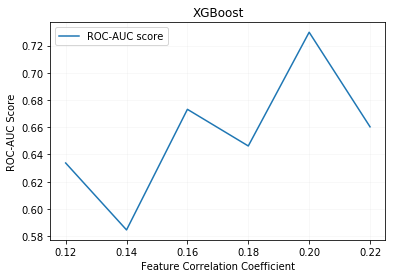

In [6]:
# params to search
xgb_params = {'n_estimators': (2, 5, 10, 20, 30, 50),
                  'learning_rate': (.01, .05, .1, .2, .3)}
xgb_scores_across_datasets = []
xgb_models = kfold_feat_select(XGB, xgb_params, xgb_scores_across_datasets)
plot_score_feature(xgb_scores_across_datasets, name="XGBoost")

## AdaBoost

Processing file 0.12_62.csv:
{'learning_rate': 0.05, 'n_estimators': 30}
{'learning_rate': 0.3, 'n_estimators': 20}
{'learning_rate': 0.01, 'n_estimators': 20}
{'learning_rate': 0.2, 'n_estimators': 20}
[ 0.744, 0.623, 0.563, 0.571 ]
The average score is 0.626

Processing file 0.14_33.csv:
{'learning_rate': 0.01, 'n_estimators': 2}
{'learning_rate': 0.1, 'n_estimators': 20}
{'learning_rate': 0.01, 'n_estimators': 2}
{'learning_rate': 0.2, 'n_estimators': 20}
[ 0.671, 0.485, 0.623, 0.543 ]
The average score is 0.581

Processing file 0.16_22.csv:
{'learning_rate': 0.01, 'n_estimators': 2}
{'learning_rate': 0.3, 'n_estimators': 50}
{'learning_rate': 0.1, 'n_estimators': 50}
{'learning_rate': 0.01, 'n_estimators': 20}
[ 0.671, 0.613, 0.637, 0.764 ]
The average score is 0.671

Processing file 0.18_12.csv:
{'learning_rate': 0.01, 'n_estimators': 2}
{'learning_rate': 0.05, 'n_estimators': 50}
{'learning_rate': 0.01, 'n_estimators': 2}
{'learning_rate': 0.05, 'n_estimators': 30}
[ 0.671, 0.634

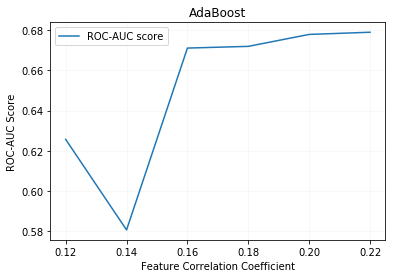

In [7]:
# params to search
ab_params = {'n_estimators': (2, 5, 10, 20, 30, 50),
                  'learning_rate': (.01, .05, .1, .2, .3)}
ab_scores_across_datasets = []
ab_models = kfold_feat_select(ABC, ab_params, ab_scores_across_datasets)
plot_score_feature(ab_scores_across_datasets, name="AdaBoost")

## Random Forest

Processing file 0.12_62.csv:
{'min_samples_leaf': 8, 'min_samples_split': 20, 'n_estimators': 20}
{'min_samples_leaf': 8, 'min_samples_split': 32, 'n_estimators': 10}
{'min_samples_leaf': 2, 'min_samples_split': 48, 'n_estimators': 20}
{'min_samples_leaf': 4, 'min_samples_split': 16, 'n_estimators': 100}
[ 0.669, 0.654, 0.581, 0.801 ]
The average score is 0.676

Processing file 0.14_33.csv:
{'min_samples_leaf': 4, 'min_samples_split': 24, 'n_estimators': 10}
{'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 5}
{'min_samples_leaf': 16, 'min_samples_split': 48, 'n_estimators': 20}
{'min_samples_leaf': 2, 'min_samples_split': 24, 'n_estimators': 20}
[ 0.784, 0.569, 0.583, 0.788 ]
The average score is 0.681

Processing file 0.16_22.csv:
{'min_samples_leaf': 6, 'min_samples_split': 8, 'n_estimators': 10}
{'min_samples_leaf': 4, 'min_samples_split': 20, 'n_estimators': 10}
{'min_samples_leaf': 2, 'min_samples_split': 24, 'n_estimators': 10}
{'min_samples_leaf': 2, 'min_samples_

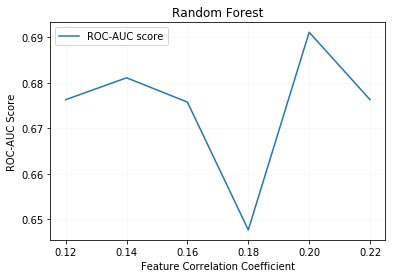

In [8]:
# params to search
rf_params = {'n_estimators': (5, 10, 20, 30, 50, 100),
          'min_samples_split': (8, 16, 20, 24, 32, 48),
          'min_samples_leaf': (2, 4, 6, 8, 16)}
rf_scores_across_datasets = []
rf_models = kfold_feat_select(RFC, rf_params, rf_scores_across_datasets)
plot_score_feature(rf_scores_across_datasets, name="Random Forest")